In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 4
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    # Save the model state after each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

print('Finished Training')


[Epoch 1, Batch 100] loss: 0.883
[Epoch 1, Batch 200] loss: 0.202
[Epoch 1, Batch 300] loss: 0.143
[Epoch 1, Batch 400] loss: 0.110
[Epoch 1, Batch 500] loss: 0.104
[Epoch 1, Batch 600] loss: 0.083
[Epoch 1, Batch 700] loss: 0.081
[Epoch 1, Batch 800] loss: 0.073
[Epoch 1, Batch 900] loss: 0.060
[Epoch 2, Batch 100] loss: 0.067
[Epoch 2, Batch 200] loss: 0.052
[Epoch 2, Batch 300] loss: 0.050
[Epoch 2, Batch 400] loss: 0.053
[Epoch 2, Batch 500] loss: 0.041
[Epoch 2, Batch 600] loss: 0.050
[Epoch 2, Batch 700] loss: 0.040
[Epoch 2, Batch 800] loss: 0.048
[Epoch 2, Batch 900] loss: 0.043
[Epoch 3, Batch 100] loss: 0.037
[Epoch 3, Batch 200] loss: 0.036
[Epoch 3, Batch 300] loss: 0.034
[Epoch 3, Batch 400] loss: 0.035
[Epoch 3, Batch 500] loss: 0.040
[Epoch 3, Batch 600] loss: 0.039
[Epoch 3, Batch 700] loss: 0.033
[Epoch 3, Batch 800] loss: 0.038
[Epoch 3, Batch 900] loss: 0.038
[Epoch 4, Batch 100] loss: 0.029
[Epoch 4, Batch 200] loss: 0.024
[Epoch 4, Batch 300] loss: 0.024
[Epoch 4, 

# Feature visualization

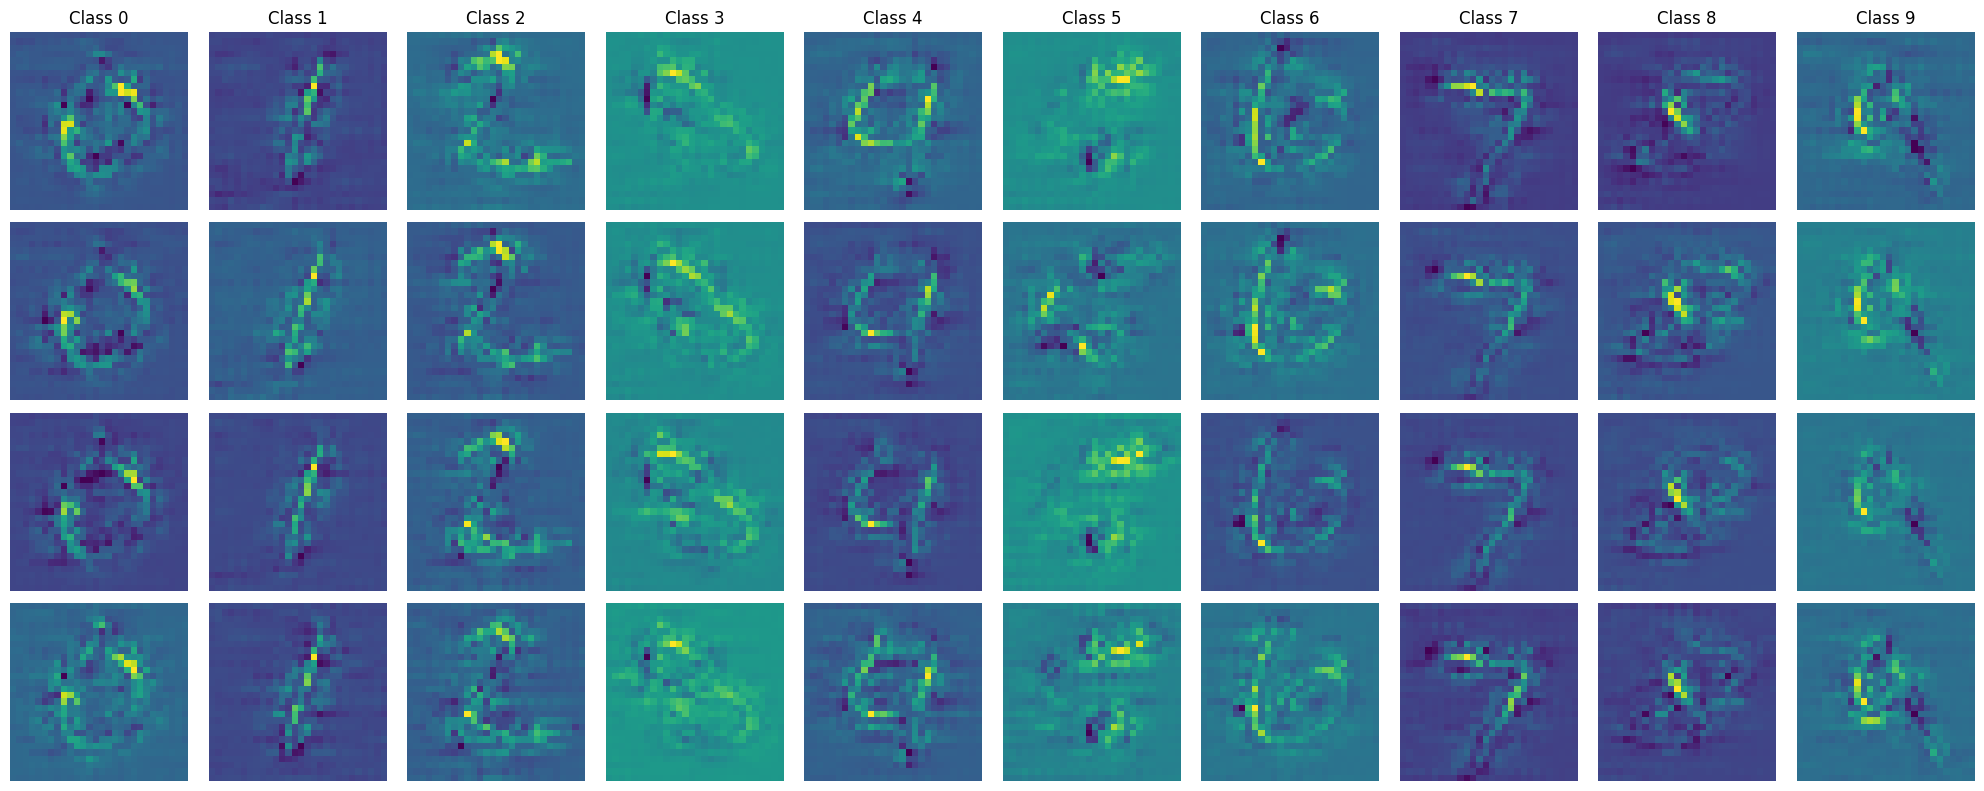

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Integrated Gradients
def integrated_gradients(model, input, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input)

    # Scale the input and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (input - baseline) for i in range(0, steps+1)]
    gradients = []

    for scaled_input in scaled_inputs:
        scaled_input = scaled_input.requires_grad_()
        output = model(scaled_input)
        loss = output[0, target_class]
        model.zero_grad()
        loss.backward(retain_graph=True)
        gradients.append(scaled_input.grad.data.cpu().numpy())

    gradients = np.array(gradients)
    avg_gradients = np.mean(gradients[:-1], axis=0)

    integrated_grad = (input.cpu().numpy() - baseline.cpu().numpy()) * avg_gradients
    return integrated_grad

def visualize_attributions_grid(attributions_dict, original_images_dict, epochs):
    fig, axes = plt.subplots(epochs, 10, figsize=(20, 2 * epochs))
    for epoch in range(epochs):
        for class_label in range(10):
            ax = axes[epoch, class_label]
            original_image = np.squeeze(original_images_dict[class_label])
            attributions = np.squeeze(attributions_dict[(class_label, epoch)])
            ax.imshow(attributions, cmap='viridis')
            if epoch == 0:
                ax.set_title(f'Class {class_label}')
            if class_label == 0:
                ax.set_ylabel(f'Epoch {epoch + 1}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select one image per class
class_images = {}
for image, label in testset:
    if label not in class_images:
        class_images[label] = image.unsqueeze(0)
    if len(class_images) == 10:
        break

# Dictionary to store attributions for each class and epoch
attributions_dict = {}
original_images_dict = {label: img for label, img in class_images.items()}

# Compute Integrated Gradients after each epoch
for epoch in range(epochs):
    # Load the model state
    model.load_state_dict(torch.load(f'model_epoch_{epoch+1}.pth'))
    for class_label, image in class_images.items():
        predicted_class = torch.argmax(model(image))
        attributions = integrated_gradients(model, image, predicted_class)
        attributions_dict[(class_label, epoch)] = attributions

# Visualize the attributions in a grid
visualize_attributions_grid(attributions_dict, original_images_dict, epochs)
